In [24]:
from nba_api.stats.endpoints import leagueleaders
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from nba_api.stats.endpoints import leaguedashplayerstats, synergyplaytypes
from nba_api.stats.endpoints import teamyearbyyearstats, playercareerstats
from nba_api.stats.static.players import find_players_by_full_name, find_player_by_id

from matplotlib.offsetbox import OffsetImage, AnnotationBbox, DrawingArea, TextArea
from matplotlib.patches import Circle, FancyArrowPatch, FancyArrow, ArrowStyle, Arrow
import matplotlib.ticker as mtick
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
import numpy as np
import functools
import seaborn as sns


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.style.use('fivethirtyeight')

/var/folders/wg/8c_xwvyn2tl18ply9w25rmgm0000gn/T/ipykernel_34519/889999587.py:20: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [39]:
# excel_df = pd.read_excel('/Users/franhuzjan/Downloads/BBM_Projections.xls')

excel_df = pd.read_csv('/Users/franhuzjan/Downloads/bbmonster_data.csv')
# excel_df[excel_df['Pos'] == 'PG'].head(5)

# excel_df[excel_df['Name'] != 'nan']

# len(excel_df)

excel_df = excel_df[excel_df['Name'].notna()]

excel_df.head()

,Unnamed: 0,Own,Round,Rank,Y!Adp,Y!XRank,Y!%,Adv%,Adv+-,Value,...,to/g,pV,3V,rV,aV,sV,bV,fg%V,ft%V,toV
1,1,,1.0,1.0,1 (0),1 (0),100.0,,,0.77,...,3.4,1.04,-0.88,2.44,2.44,0.64,0.10,2.67,0.41,-1.93
2,2,IR,1.0,2.0,3 (+1),3 (+1),99.0,,,0.72,...,3.2,2.56,-0.48,1.76,0.04,-0.09,1.46,1.36,1.49,-1.62
3,3,,1.0,3.0,6 (+3),6 (+3),100.0,,,0.66,...,2.6,0.81,1.23,-1.01,3.25,1.99,-0.33,-0.01,0.91,-0.93
4,4,,1.0,4.0,6 (+2),5 (+1),100.0,,,0.63,...,2.8,2.31,-0.66,-0.46,0.55,1.88,0.11,0.35,2.74,-1.12
5,5,,1.0,5.0,7 (+2),7 (+2),99.0,,,0.62,...,3.2,2.07,3.00,-0.24,0.96,0.46,-0.61,-0.31,1.90,-1.61


In [40]:
for column in excel_df.columns:
    print(column)

Unnamed: 0
Own
Round
Rank
Y!Adp
Y!XRank
Y!%
Adv%
Adv+-
Value
DURANT
PosV
MonsterBargame
Name
Team
Pos
Note
Inj
Inj Risk
Status
Conf
Role
g
Playoff
QG
b2b
m/g
p/g
3/g
r/g
a/g
s/g
b/g
fg%
fga/g
ft%
fta/g
to/g
pV
3V
rV
aV
sV
bV
fg%V
ft%V
toV


In [42]:
columns_to_keep = ['Rank', 'Y!Adp', 'Y!XRank', 
                   'Value',
                   'Pos',
                   # 'PuntV',
                   'DURANT',
                   # 'Minus1V',
                   'Name']

df = excel_df[columns_to_keep]

# df = df.drop(df[df['Y!Adp'] <= 0].index)

df['Pos'] = df.apply(lambda row: row['Pos'].split('/')[0] if '/' in row['Pos'] else row['Pos'], axis=1)

df['DURANT'] = df.apply(lambda row: float(row['DURANT'].split('#')[0]), axis=1)


df['Pos'] = pd.Categorical(df['Pos'], ['PG', 'SG', 'SF', 'PF', 'C'])

df = df.sort_values('Pos')

df.head()

/var/folders/wg/8c_xwvyn2tl18ply9w25rmgm0000gn/T/ipykernel_34519/427132031.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pos'] = df.apply(lambda row: row['Pos'].split('/')[0] if '/' in row['Pos'] else row['Pos'], axis=1)
/var/folders/wg/8c_xwvyn2tl18ply9w25rmgm0000gn/T/ipykernel_34519/427132031.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DURANT'] = df.apply(lambda row: float(row['DURANT'].split('#')[0]), axis=1)
/var/folders/wg/8c_xwvyn2tl18ply9w25rmgm0000gn/T/ipykernel_34519/4271320

,Rank,Y!Adp,Y!XRank,Value,Pos,DURANT,Name
101,94.0,95 (+1),78 (-16),-0.12,PG,0.68,Markelle Fultz
112,104.0,76 (-28),70 (-34),-0.14,PG,0.68,Tyler Herro
109,101.0,80 (-21),92 (-9),-0.13,PG,0.59,Anfernee Simons
99,92.0,133 (+41),164 (+72),-0.11,PG,0.66,Ben Simmons
98,91.0,72 (-19),63 (-28),-0.10,PG,0.71,Derrick White


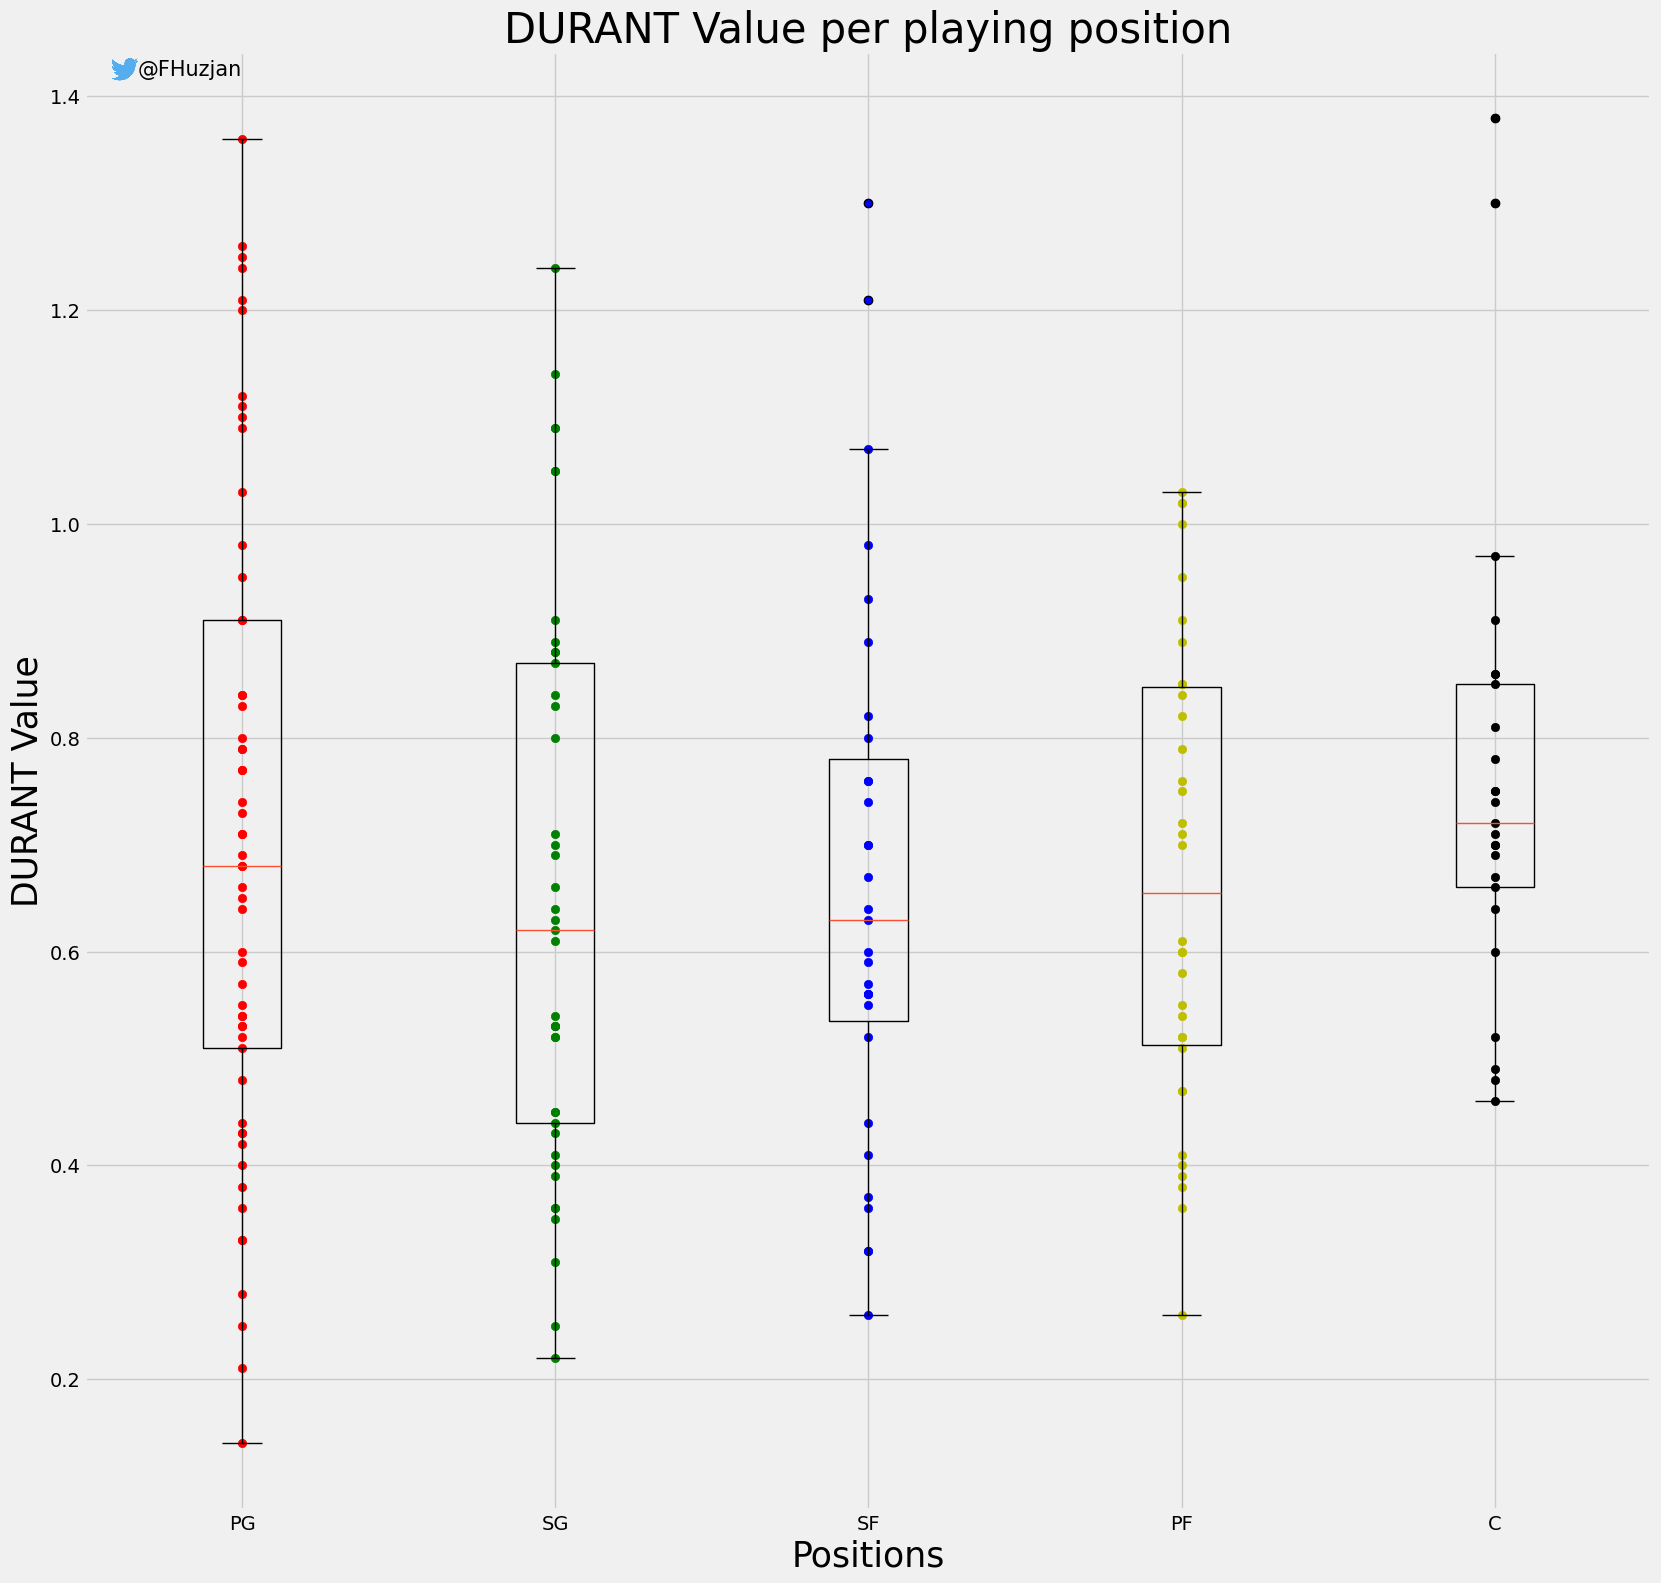

In [47]:
fig, ax = plt.subplots(figsize=(18, 18))

color_dict = {'PG': 'r',
              'SG': 'g',
              'SF': 'b',
              'PF': 'y',
              'C': 'black'}

cat = 'DURANT'

for i in range(len(df)):
    
    player = df.iloc[i]
        
    ax.scatter(player['Pos'], player[cat], color=color_dict[player['Pos']])
    
    # df_to_draw.median()
    
    # print(play_type, len(df[df['PPP'] > 1]['PPP']))
    
    # ab = AnnotationBbox(TextArea('Median'), (i, df_to_draw.median()), frameon=False)
    # ax.add_artist(ab)

boxplot_lists = []
for position, color in color_dict.items():
        boxplot_lists.append(df[df['Pos'] == position][cat])


ax.boxplot(boxplot_lists, widths=0.25, positions=[0, 1, 2, 3, 4])

ax.set_xlabel("Positions", fontsize=25)
ax.set_ylabel("DURANT Value", fontsize=25)
ax.set_xticks(list(range(len(color_dict.keys()))))
ax.set_xticklabels(list(color_dict.keys()))
plt.title('DURANT Value per playing position', fontsize=30)
ab = AnnotationBbox(OffsetImage(plt.imread(f'twitter_logo (1).png'), zoom=0.1), (-0.375, 1.425), frameon=False)
ax.add_artist(ab)
ax.text(x=0, y=1.42, ha='right', s='@FHuzjan', size=15)
plt.savefig('Graphs/durant_boxplot_value.png', bbox_inches='tight')

In [50]:
df[df['Pos'] == 'SF'].sort_values(by='DURANT',ascending=False)

,Rank,Y!Adp,Y!XRank,Value,Pos,DURANT,Name
11,11.0,11 (0),11 (0),0.42,SF,1.30,Kevin Durant
12,12.0,5 (-7),4 (-8),0.42,SF,1.21,Jayson Tatum
23,22.0,26 (+4),27 (+5),0.25,SF,1.07,LeBron James
30,28.0,26 (-2),31 (+3),0.23,SF,0.98,Lauri Markkanen
15,14.0,27 (+13),24 (+10),0.38,SF,0.93,Jimmy Butler
68,63.0,87 (+24),83 (+20),0.03,SF,0.89,Khris Middleton
74,69.0,100 (+31),82 (+13),0.00,SF,0.82,Tobias Harris
45,42.0,65 (+23),66 (+24),0.12,SF,0.80,Cam Johnson
96,89.0,93 (+4),81 (-8),-0.08,SF,0.76,Miles Bridges
92,85.0,56 (-29),51 (-34),-0.07,SF,0.76,Scottie Barnes


In [52]:
np.median(df[df['Pos'] == 'C']['DURANT'])

0.72

In [77]:
table_df = pd.read('/Users/franhuzjan/Desktop/projections.html')

ImportError: lxml not found, please install it

In [76]:
!pip install lxml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 4.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
anceled
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
